<a href="https://colab.research.google.com/github/Ananya-AJ/Deep-Learning/blob/main/Assignment_3/Assignment_3_part_h.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Write a colab in JAX only from scratch 3 layer deep neural network for non linear regression using low-level and high-level API

In [1]:
#imports
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import plotly.graph_objects as go

In [3]:
#Generate data
n = 300
d = 3
key = random.PRNGKey(0)
x = random.uniform(key, (n, d), minval=-1, maxval=1)

weights = np.array([[2.0, -3.0, 1.0]]).T
bias = np.array([1])

print('Weights shape =', weights.shape)
print('Bias shape =', bias.shape)

# non-linear 3 variable function we want to learn
y_true = np.einsum('ij, jk -> ik', (x**3),  weights) + np.einsum('ij, jk -> ik', (x**2),  weights) + np.einsum('ij, jk -> ik', x, weights) + bias
print('Function output shape =', y_true.shape)

Weights shape = (3, 1)
Bias shape = (1,)
Function output shape = (300, 1)


In [7]:
def plot_3d(x, y, y_pred=None):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='our function')
  plt.legend()

In [8]:
def plot_4d(x, y, y_pred=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y.flatten(), cmap='Blues_r', label='underlying function')
    if y_pred is not None:
        ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y_pred.flatten(), cmap='Reds_r', label='our function')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()

Using low level API

In [4]:
#Using Gradient descent and mean sum of square errors to calculate the loss and gradient, to update the weights and bias such that loss is minimized
class MSE:
    def __call__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        return jnp.mean((y_pred - y_true) ** 2)
    
    def backward(self):
      n = self.y_true.shape[0]
      self.gradient = 2. * (self.y_pred - self.y_true) / n
      return self.gradient


In [5]:
#weights and bias are initialized to a random value
#calculate output by multiplying input with weights and add bias
#In backward propogation function, the weights gradient and bias gradient are calculated based on their gradient values and are updated

class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    key = random.PRNGKey(0)
    #x = random.uniform(key, (n, d), minval=-1, maxval=1)
    self.weights = random.uniform(key, (input_dim, num_hidden)) * jnp.sqrt(2. / input_dim)
    self.bias = jnp.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

In [6]:
#Training
from typing import Callable

def fit(x: jnp.ndarray, y: jnp.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

Epoch 0, loss 13.376266479492188
Epoch 1, loss 11.724611282348633
Epoch 2, loss 10.34055233001709
Epoch 3, loss 9.168977737426758
Epoch 4, loss 8.169398307800293
Epoch 5, loss 7.311337471008301
Epoch 6, loss 6.571310997009277
Epoch 7, loss 5.930815696716309
Epoch 8, loss 5.374974727630615
Epoch 9, loss 4.8916215896606445
Epoch 10, loss 4.470656871795654
Epoch 11, loss 4.103600025177002
Epoch 12, loss 3.783261775970459
Epoch 13, loss 3.503502607345581
Epoch 14, loss 3.259049415588379
Epoch 15, loss 3.0453543663024902
Epoch 16, loss 2.858482837677002
Epoch 17, loss 2.695019245147705
Epoch 18, loss 2.5519967079162598
Epoch 19, loss 2.4268321990966797
Epoch 20, loss 2.3172755241394043
Epoch 21, loss 2.2213635444641113
Epoch 22, loss 2.137383460998535
Epoch 23, loss 2.063840389251709
Epoch 24, loss 1.9994279146194458
Epoch 25, loss 1.943004846572876
Epoch 26, loss 1.8935734033584595
Epoch 27, loss 1.8502625226974487
Epoch 28, loss 1.8123092651367188
Epoch 29, loss 1.779046654701233
Epoch 30

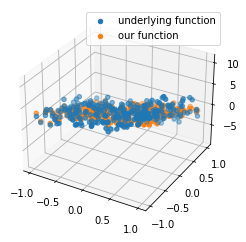

In [10]:
loss = MSE()
linear = Linear(d)
fit(x, y_true, model=linear, loss=loss, lr=0.1, num_epochs=50)
plot_3d(x, y_true, linear(x))

High level API - Introducing non-linearity in the neural network with a non-linear activation function - using Relu.


In [11]:
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = jnp.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      #to debug 
      #import pdb
      #pdb.set_trace() 
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient

107.53267


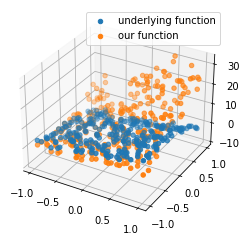

In [12]:
#performing one pass of forward and backward propogation
class Model:
  def __init__(self, input_dim, num_hidden1, num_hidden2):
    self.linear1 = Linear(input_dim, num_hidden1)
    self.relu1 = Relu()
    self.linear2 = Linear(num_hidden1, num_hidden2)
    self.relu2 = Relu()
    self.linear3 = Linear(num_hidden2, 1)
  
  def __call__(self, x):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3
  
  def backward(self, output_gradient):
    linear3_gradient = self.linear3.backward(output_gradient)
    relu2_gradient = self.relu2.backward(linear3_gradient)
    linear2_gradient = self.linear2.backward(relu2_gradient)
    relu1_gradient = self.relu1.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu1_gradient)
    # print('Model backward', linear2_gradient.shape, relu_gradient.shape, linear1_gradient.shape)
    # import pdb; pdb.set_trace()
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

loss = MSE()
model = Model(d,100,40)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
loss_gradient = loss.backward()
print(loss_value)
model.backward(loss_gradient)
plot_3d(x, y_true, y_pred)

#Neural network for non-linear Regression using Relu activation function using three layers(input layer,hidden layer and output layer)


Epoch 0, loss 5.109042167663574
Epoch 1, loss 5.108896732330322
Epoch 2, loss 5.108750343322754
Epoch 3, loss 5.108606338500977
Epoch 4, loss 5.108460426330566
Epoch 5, loss 5.1083173751831055
Epoch 6, loss 5.108171463012695
Epoch 7, loss 5.108026027679443
Epoch 8, loss 5.10788106918335
Epoch 9, loss 5.107737064361572
Epoch 10, loss 5.107591152191162
Epoch 11, loss 5.107448101043701
Epoch 12, loss 5.107304573059082
Epoch 13, loss 5.10715913772583
Epoch 14, loss 5.107016563415527
Epoch 15, loss 5.106873035430908
Epoch 16, loss 5.106727123260498
Epoch 17, loss 5.106586456298828
Epoch 18, loss 5.106442451477051
Epoch 19, loss 5.106300354003906
Epoch 20, loss 5.106159210205078
Epoch 21, loss 5.106014728546143
Epoch 22, loss 5.105872631072998
Epoch 23, loss 5.1057329177856445
Epoch 24, loss 5.105589389801025
Epoch 25, loss 5.1054487228393555
Epoch 26, loss 5.105309963226318
Epoch 27, loss 5.105169296264648
Epoch 28, loss 5.1050286293029785
Epoch 29, loss 5.104889869689941
Epoch 30, loss 5.1

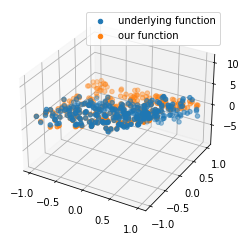

In [14]:
fit(x, y_true, model=model, loss=loss, lr=0.01, num_epochs=1000)
plot_3d(x, y_true, model(x))

loss is reduced as the epochs increase, The neural network has learnt the underlying function well as per the graph above at just one pass.